# Análisis espectral de microsismicidad y ruido ambiental para el canal de velocidad vertical (EHZ)

**Autor:** A. Isaac P.S.

**Fecha:** 2025-08-07

Este cuadernillo aplica **ObsPy** para importar y analizar sismicidad local grabada por la red de sismógrafos de SkyAlert en la Ciudad de México con el canal de velocidad vertical. Para ello, se calculan los **espectros de potencia** para **estimar la frecuencia de esquina** (*corner frequency, $f_c$*).
Con $f_c$ propondremos un **filtro** que maximice la resolución de la energía sísmica de los microsismos en nuestro flujo interno.


## 0. Objetivos
- Cargar una o varias trazas de velocidad en formato MiniSEED de algunos microsismos y señales de ruido de distinta naturaleza y duración.
- Pre-procesar los datos para eliminar la tendencia natural.
- Calcular espectros de amplitud/PSD usando la teoría de Fourier.
- A partir de un análisis cualitativo de los especogramas, **estimar la frecuencia de esquina $f_c$**.
- Proponer y probar un **filtro** (p.ej. banda/alto) en torno a $f_c$.
- Validar los resultados del filtro aplicando STA/LTA con los parámetros actuales del sistema de microsismos para los cuatro canales y contabilizar el número de falsas activaciones antes y despúes del filtro propuesto.
- Guardar figuras y resultados clave para su integración al sistema.


## 1. Instalación y librerías



In [4]:
# === Imports ===
import numpy as np
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime
from scipy.signal import welch
from obspy.signal.trigger import classic_sta_lta, trigger_onset
import pandas as pd

## 2. Carga de datos
Se trabaja con los siguientes eventos:
- Traza 1: M2.7 del 27 de septiembre de 2024 (R9837).
- Traza 2: M2.9 del 27 de septiembre de 2024 (RB52D).
- Traza 3: M2.0 del 7 de octubre de 2024 (R5FE1).
- Traza 4: M1.9 del 18 de noviembre de 2024 (RB604).
- Trazas 5 y 6: M1.9 del 18 de junio de 2025 (R03B7 y R9837).
- Trazas 7 y 8: M2.3 del 24 de junio de 2025 (R9837 y R03B7).
- Trazas 9 y 10: Trueno del 10 de agosto de 2025 (R88E8 y R8712).
- Trazas 11 y 12: Ruido del 25 de agosto de 2025 (RB604 y R03B7).
- Trazas 13 y 14: Ruido impulsivo del 28 de agosto de 2025 (R5FE1 y R9561).


In [6]:
# Rutas de archivos MiniSEED
rutas = [
    "Corner Frequency/M27-27-sep-2024-R9837.mseed",
    "Corner Frequency/M29-27-sep-2024-RB52D.mseed",
    "Corner Frequency/M20-7-oct-2024-R5FE1.mseed",
    "Corner Frequency/M19-18-nov-2024-RB604.mseed",
    "Corner Frequency/M19-18-jun-2025-R03B7.mseed",
    "Corner Frequency/M19-18-jun-2025-R9837.mseed",
    "Corner Frequency/M23-24-jun-2025-R9837.mseed",
    "Corner Frequency/M23-24-jun-2025-R03B7.mseed",
    "Corner Frequency/Trueno-10-ago-2025-R88E8.mseed",
    "Corner Frequency/Trueno-10-ago-2025-R8712.mseed",
    "Corner Frequency/Ruido-25-ago-2025-RB604.mseed",
    "Corner Frequency/Ruido-25-ago-2025-R03B7.mseed",
    "Corner Frequency/Ruido-28-ago-2025-R5FE1.mseed",
    "Corner Frequency/Ruido-28-ago-2025-R9561.mseed"
]

# Leer y preprocesar todas las trazas
trazas = []
for ruta in rutas:
    tr = read(ruta)[0]        # tomar la primera traza
    tr.detrend(type="simple") # quitar tendencia
    trazas.append(tr)

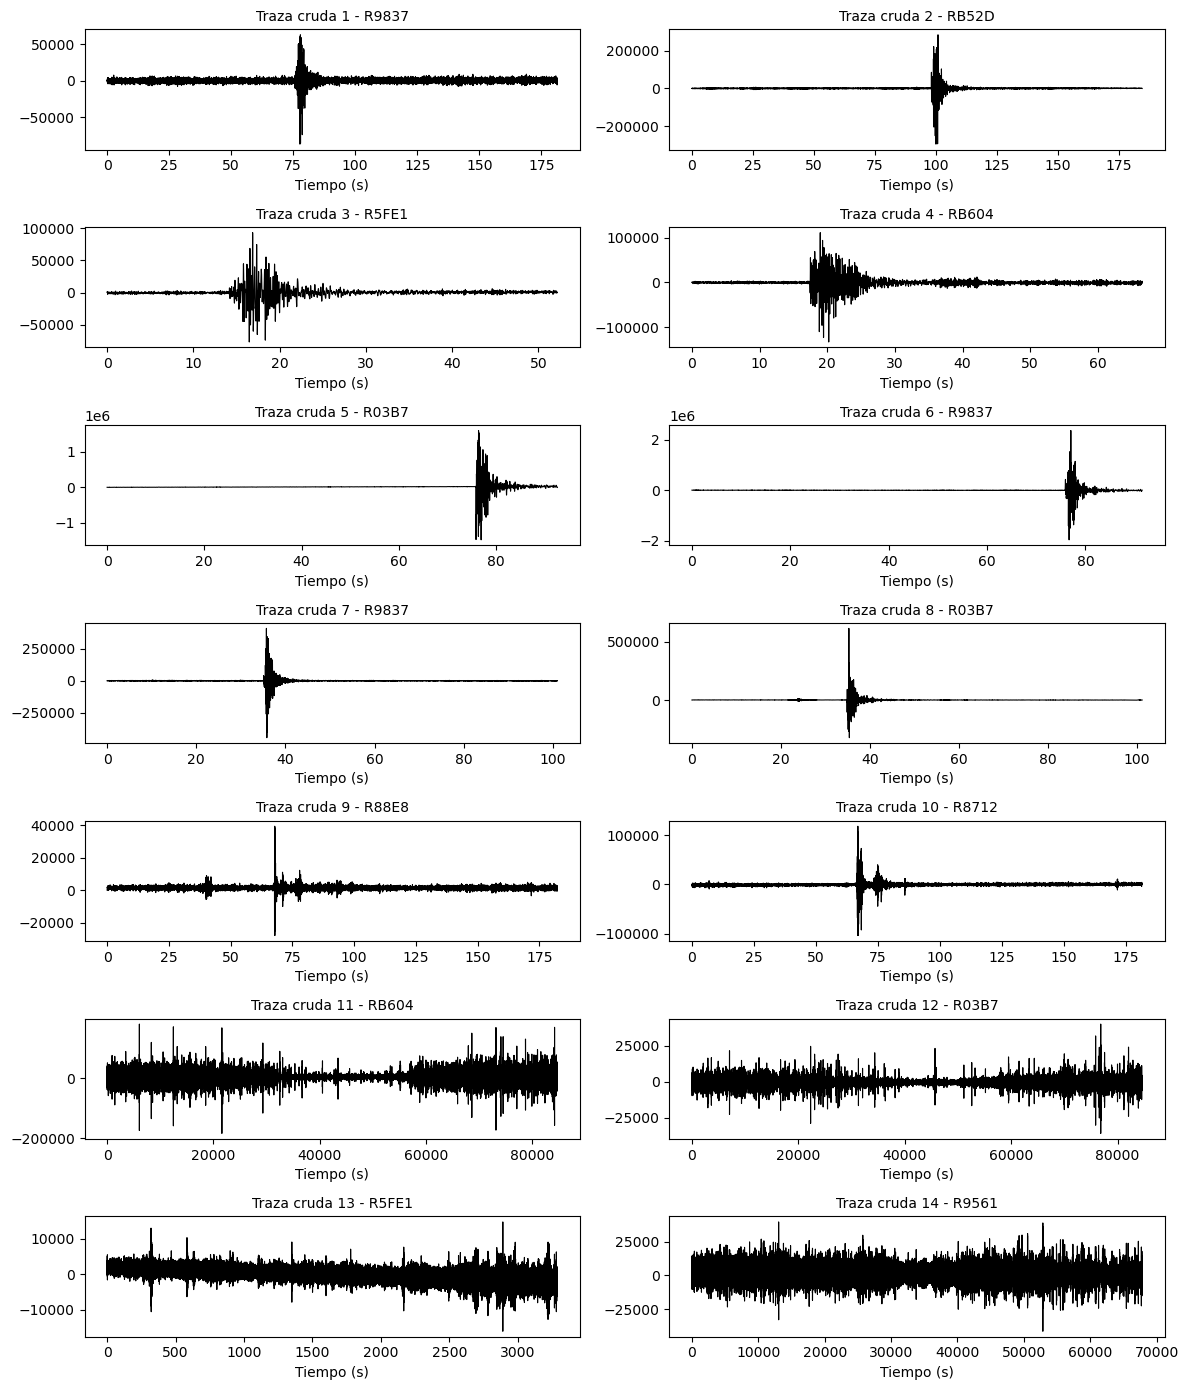

In [7]:
# Graficar todas las trazas
fig, axes = plt.subplots(7, 2, figsize=(12, 14), sharex=False, sharey=False)
axes = axes.flatten()  # aplanar para indexar fácilmente

for i, tr in enumerate(trazas):
    t = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts)
    axes[i].plot(t, tr.data, color="black", linewidth=0.8)
    axes[i].set_title(f"Traza cruda {i+1} - {tr.stats.station}", fontsize=10)
    axes[i].set_xlabel("Tiempo (s)")

plt.tight_layout()
plt.show()



## 3. Teoría de Fourier (muy breve)

Una serie temporal $x(t)$ puede representarse en el dominio de la frecuencia mediante la **Transformada de Fourier**:

$$
X(f) = \int_{-\infty}^{\infty} x(t) e^{-i 2\pi f t} \, dt,
$$

El espectro de potencia, también llamado densidad espectral de potencia (PSD), se define como el cuadrado del valor absoluto de los coeficientes de Fourier, es decir:

$$
PSD(f) = |X(f)|^2 ,
$$

En la práctica, usamos la Transformada Rápida de Fourirer (**FFT**) sobre ventanas finitas para señales discretas $x[n]$ con frecuencia de muestreo $f_s$, la cúal se define como:

$$
X[k] = \sum_{n=0}^{N-1} x[n] \, e^{-i 2 \pi \frac{kn}{N}},
$$

De esta forma, el espectro de potencia permite analizar cómo se distribuye la 
energía de la señal en función de la frecuencia. Para señales sísmicas locales, el espectro presenta una zona de baja frecuencia (controlada por el nivel de ruido y la respuesta instrumental) y otra de alta frecuencia donde el decaimiento tiende a $f_s^{-2}$.

La **frecuencia de esquina** $f_c$ marca el cambio de pendiente entre el tramo plano (o poco inclinado) y el tramo de fuerte decaimiento.



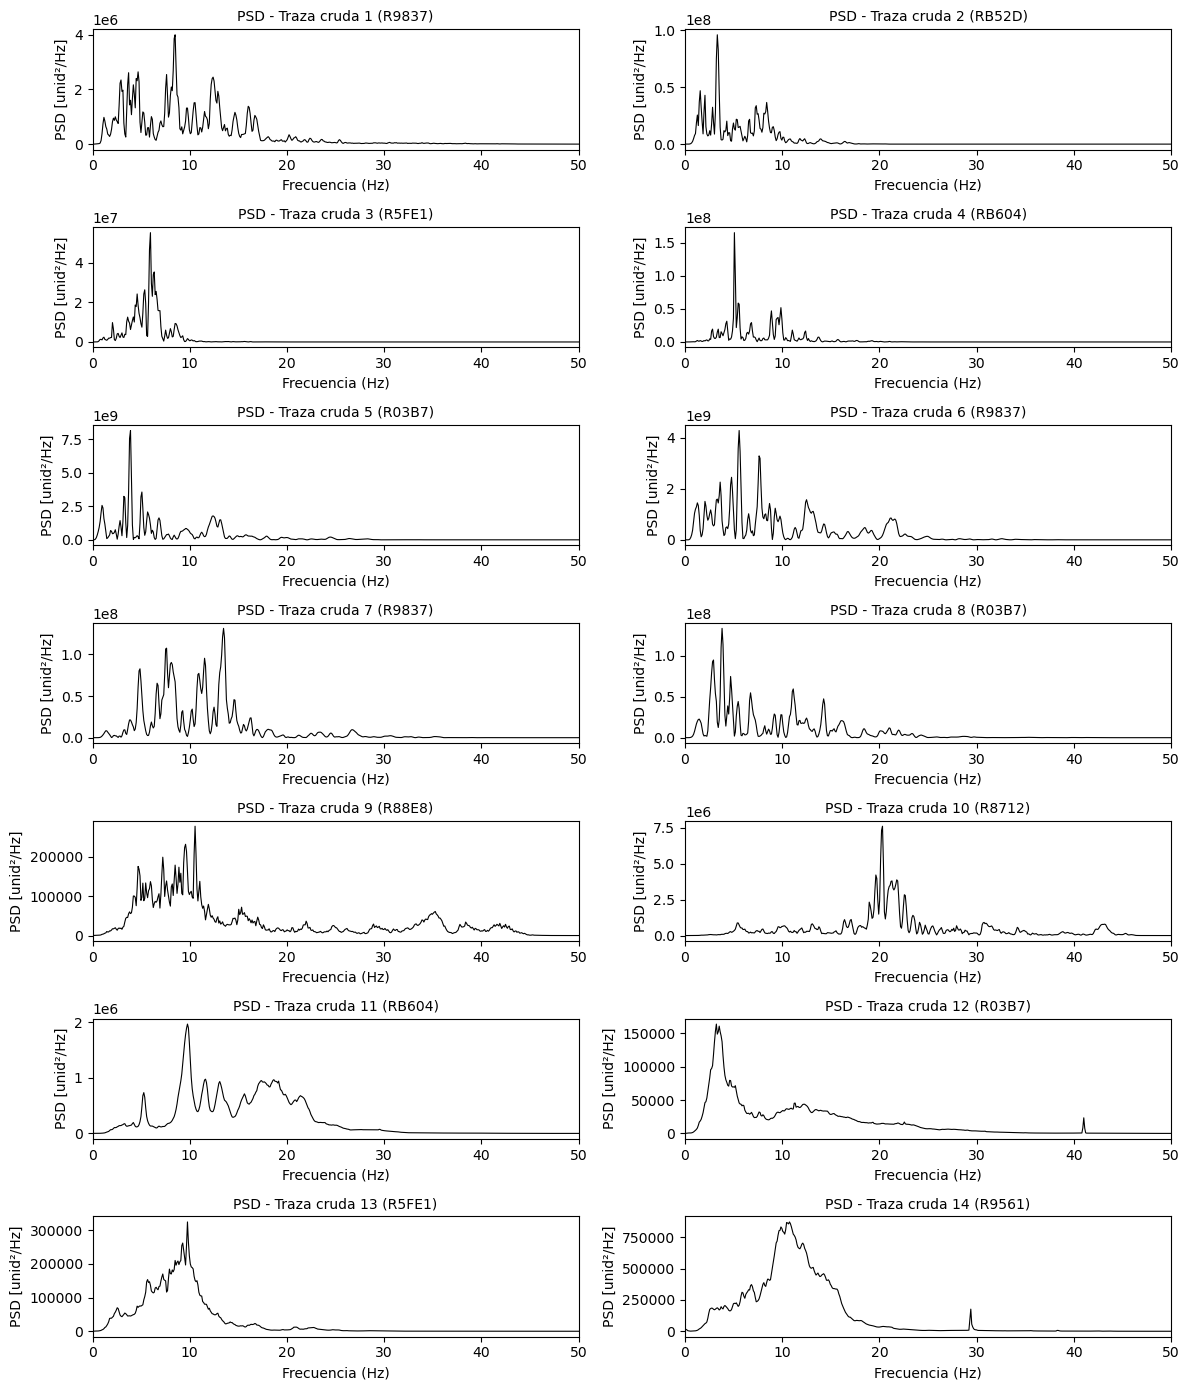

In [9]:
# Parámetros generales
# ----------------------------
fs = 100.0
fmax = fs/2  # 50 Hz
nperseg = 1024  # Welch

# Graficar espectros de potencia
fig, axes = plt.subplots(7, 2, figsize=(12, 14))
axes = axes.flatten()

for i, tr in enumerate(trazas):
    # Calcular espectro de potencia con Welch
    f, Pxx = welch(tr.data, fs=fs, nperseg=1024)
    # Graficar hasta Nyquist
    axes[i].plot(f, Pxx, color="black", linewidth=0.8)
    axes[i].set_xlim(0, fmax)
    axes[i].set_title(f"PSD - Traza cruda {i+1} ({tr.stats.station})", fontsize=10)
    axes[i].set_xlabel("Frecuencia (Hz)")
    axes[i].set_ylabel("PSD [unid²/Hz]")

plt.tight_layout()
plt.show()


## 4. Análisis cualitativo de los espectros de potencia (señales crudas)

### Microsismos (Trazas 1 a 8)
El contenido espectral de los microsismos analizados se distribuye principalmente entre **0 y 28 Hz**, presentando **picos de mayor potencia entre 3 y 7 Hz**.  
La excepción corresponde a la **traza 7**, la cual proviene de un evento sísmico registrado a una distancia considerable de la fuente (mayor a 700 m), mostrando un patrón ligeramente diferente en su espectro.  

Se observa que la **potencia máxima alcanzada en estas trazas siempre supera las $3\times 10^6$ unidades de potencia**. En las **bajas frecuencias (< 3 Hz)**, la energía está dominada por el **ruido base del sitio de instalación** y por la **respuesta instrumental de los sismógrafos**.

---

### Trueno (Trazas 9 y 10)
El contenido espectral de estos eventos resulta más **variable** y depende principalmente de la **cercanía de la fuente** respecto a la estación sísmica.  

- **Traza 9**: corresponde a la estación más distante. Su espectro se asemeja al de los microsismos, con la presencia de algunos **armónicos en altas frecuencias**. Sin embargo, la **potencia máxima** es mucho menor, alcanzando valores por debajo de $10^3$ unidades de potencia.  

- **Traza 10**: corresponde a la estación más cercana. Aquí la **potencia máxima supera los $6 \times 10^6$**, concentrando su energía principalmente en torno a los **21 Hz**, con armónicos secundarios tanto en bajas como en altas frecuencias. Parte de esta energía podría incluso superar la **frecuencia de Nyquist (50 Hz)** de los instrumentos, produciendo aliasing.

---

### Ruido ambiental de 24 horas (Trazas 11 a 14)
Las trazas de ruido normal muestran un comportamiento **altamente variable**, tanto en amplitud como en la forma y rango del espectro.  
Se observó que la **potencia máxima** puede cambiar significativamente debido a **eventos aleatorios e impredecibles** que generan vibraciones transitorias.  

No obstante, en ambas trazas se identifica un **pico de energía predominante cercano a 10 Hz o por debajo de este**, atribuido a la **respuesta del suelo local** y/o al **tipo de construcción** sobre la cual se instaló el instrumento, entre otros factores.

---

## Conclusiones preliminares
Como primera aproximación, se propone la aplicación de un **filtro pasa bajas de segundo orden con frecuencia de corte suave en 21 Hz**, con el objetivo de atenuar el ruido de **altas frecuencias** asociado a:
- Actividad antropogénica (paso vehicular y peatonal),
- Fuentes atmosféricas (truenos),
- Otras vibraciones impulsivas de corta duración.  

No se recomienda el uso de filtros para las **bajas frecuencias**, ya que en algunos eventos locales hasta un **15% de su energía se concentra por debajo de 4 Hz**, y aplicar un filtro en esa banda podría **reducir la relación señal/ruido** de manera indeseada.


## 4. Aplicación del filtro



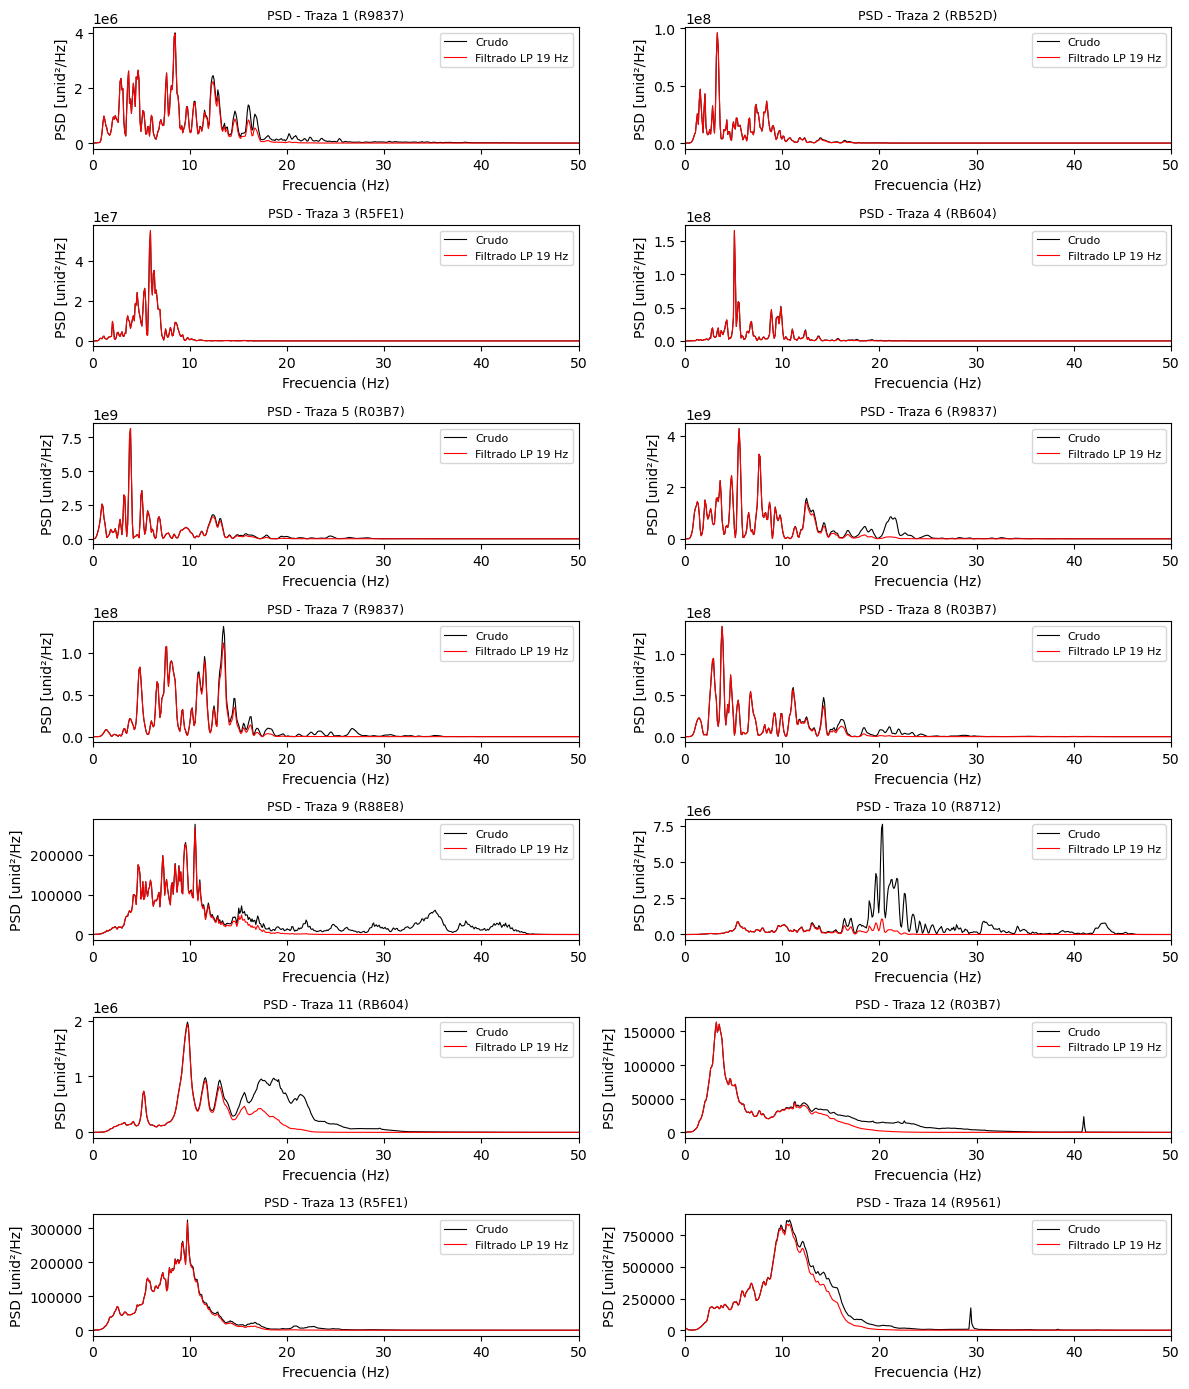

In [12]:

def lowpass_butter_obspy(tr, fc=19.0, order=3):
    tr_f = tr.copy()
    tr_f.filter("lowpass", freq=fc, corners=order, zerophase=True)
    return tr_f

def psd_welch(x, fs, nperseg=1024):
    f, Pxx = welch(x, fs=fs, nperseg=nperseg, scaling="density")
    return f, Pxx

fig2, axes2 = plt.subplots(7, 2, figsize=(12, 14))
axes2 = axes2.flatten()

for i, tr in enumerate(trazas):
    # Señal cruda
    f_raw, Pxx_raw = psd_welch(tr.data.astype(float), fs, nperseg=nperseg)
    
    # Señal filtrada (Low-pass 19 Hz, orden 3)
    trf = lowpass_butter_obspy(tr, fc=19.0, order=3)
    f_filt, Pxx_filt = psd_welch(trf.data.astype(float), fs, nperseg=nperseg)

    # Graficar ambas curvas
    axes2[i].plot(f_raw, Pxx_raw, color="black", linewidth=0.8, label="Crudo")
    axes2[i].plot(f_filt, Pxx_filt, color="red", linewidth=0.8, label="Filtrado LP 19 Hz")
    
    # Configuración de ejes
    axes2[i].set_xlim(0, fmax)
    axes2[i].set_title(f"PSD - Traza {i+1} ({getattr(tr.stats,'station','')})", fontsize=9)
    axes2[i].set_xlabel("Frecuencia (Hz)")
    axes2[i].set_ylabel("PSD [unid²/Hz]")
    axes2[i].legend(fontsize=8)

fig2.tight_layout()
plt.show()

## 5. Comparación de resultados

- Ahora aplicamos STA/LTA con los parámetros actuales del sistema de microsismos tanto para las señales crudas como filtradas y contabilizamos en ambos casos el número de falsas activaciones.

C:\Users\aisaa\AppData\Local\Temp\ipykernel_18736\2685137496.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(fontsize=7)
C:\Users\aisaa\AppData\Local\Temp\ipykernel_18736\2685137496.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
C:\Users\aisaa\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


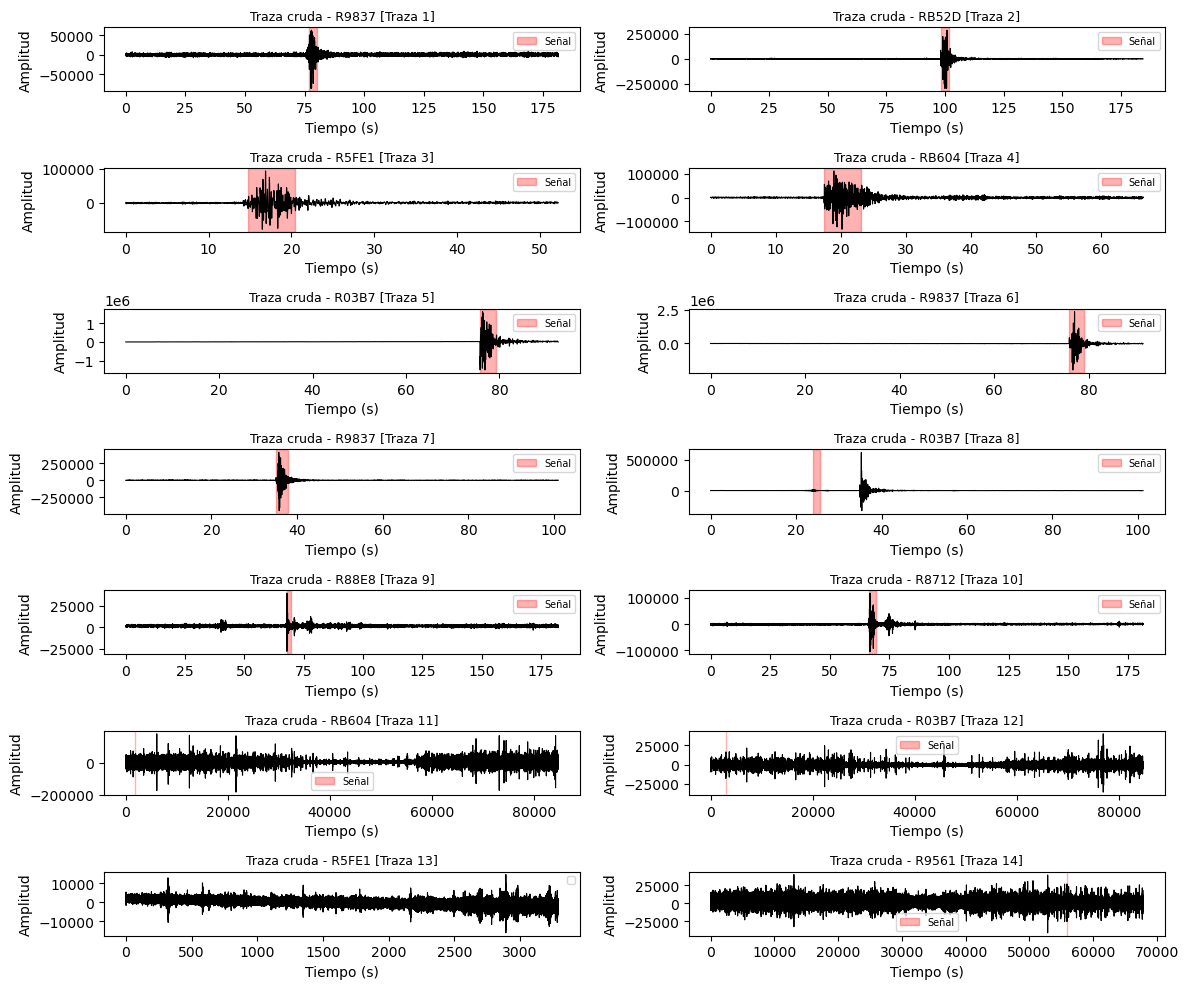

In [14]:
# Parámetros STA/LTA
nsta = int(1.0 * fs)   # ventana STA de 1 s
nlta = int(10.0 * fs)  # ventana LTA de 10 s
th_on = 6.6            # umbral de disparo
th_off = 0.8           # umbral de apagado

fig, axes = plt.subplots(7, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(14): 
    tr = trazas[i]
    data = tr.data.astype(float)

    # STA/LTA
    cft = classic_sta_lta(data, nsta, nlta)
    on_off = trigger_onset(cft, th_on, th_off)

    t = np.arange(0, len(data)) / fs
    axes[i].plot(t, data, color="black", linewidth=0.8)

    # Usamos solo la primera ventana como señal
    if len(on_off) > 0:
        on, off = on_off[0]
        axes[i].axvspan(on/fs, off/fs, color="red", alpha=0.3, label="Señal")

    axes[i].set_title(f"Traza cruda (thr_On = 6.6)- {getattr(tr.stats,'station','')} [Traza {i+1}]",
                      fontsize=9)
    axes[i].set_xlabel("Tiempo (s)")
    axes[i].set_ylabel("Amplitud")
    axes[i].legend(fontsize=7)

fig.tight_layout()
plt.show()

### Tasa de error:
- 6 de 14 trazas = 42 %
### Tasa de éxito:
- 7 de 8 trazas = 87 %

C:\Users\aisaa\AppData\Local\Temp\ipykernel_18736\2076530406.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(fontsize=7)
C:\Users\aisaa\AppData\Local\Temp\ipykernel_18736\2076530406.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


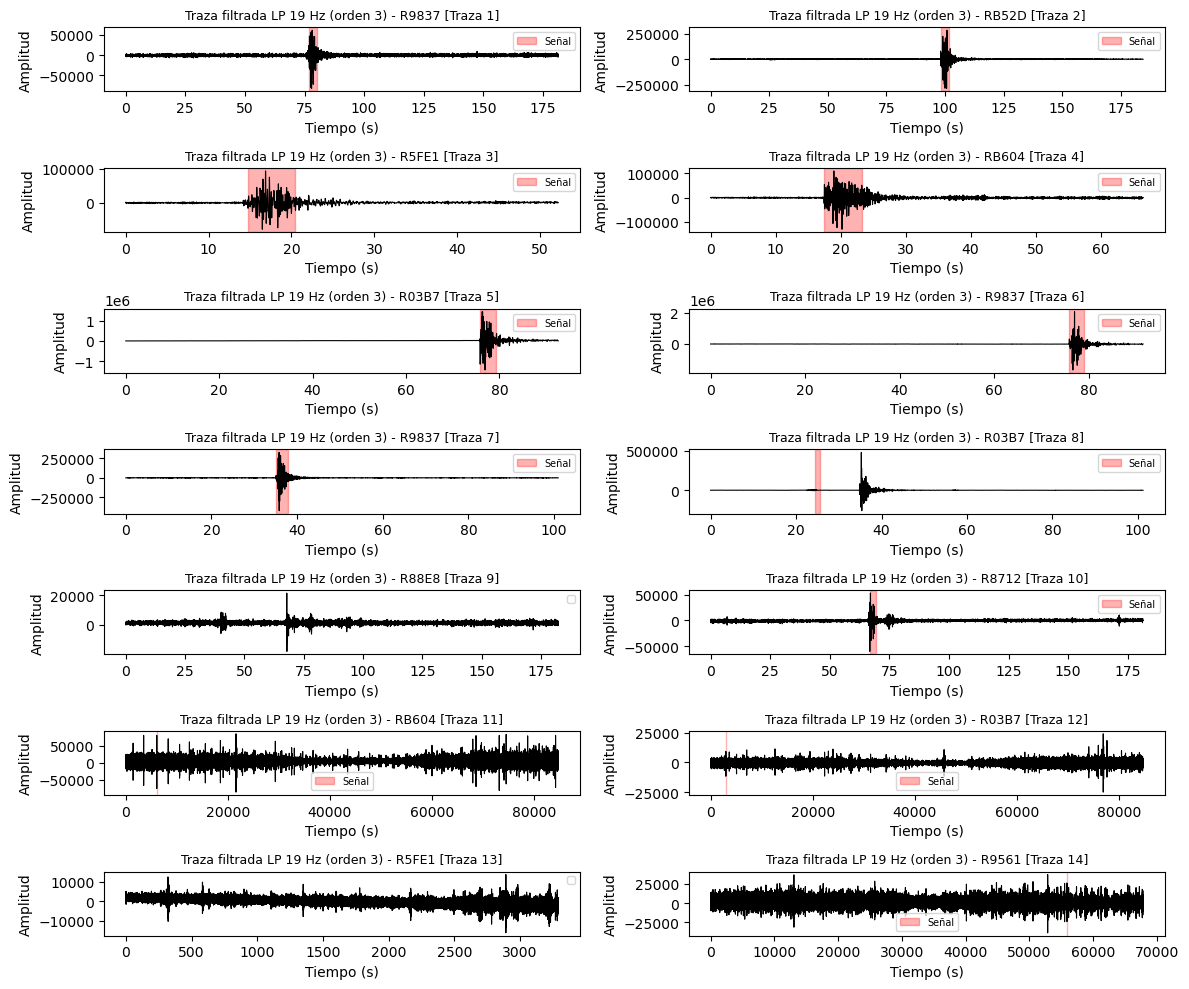

In [16]:
# Parámetros STA/LTA
nsta = int(1.0 * fs)   # ventana STA de 1 s
nlta = int(10.0 * fs)  # ventana LTA de 10 s
th_on = 6.6            # umbral de disparo
th_off = 0.8           # umbral de apagado

fig, axes = plt.subplots(7, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(14): 
    tr = trazas[i]
    # Filtrado pasa-bajas
    trf = tr.filter('lowpass', freq=19, corners=3, zerophase=True)
    data = trf.data.astype(float)

    # STA/LTA
    cft = classic_sta_lta(data, nsta, nlta)
    on_off = trigger_onset(cft, th_on, th_off)

    t = np.arange(0, len(data)) / fs
    axes[i].plot(t, data, color="black", linewidth=0.8)

    # Usamos solo la primera ventana como señal
    if len(on_off) > 0:
        on, off = on_off[0]
        axes[i].axvspan(on/fs, off/fs, color="red", alpha=0.3, label="Señal")

    axes[i].set_title(f"Traza filtrada LP 19 Hz (orden 3) - {getattr(tr.stats,'station','')} [Traza {i+1}]",
                      fontsize=9)
    axes[i].set_xlabel("Tiempo (s)")
    axes[i].set_ylabel("Amplitud")
    axes[i].legend(fontsize=7)

fig.tight_layout()
plt.show()

### Tasa de error:
- 5 de 14 trazas = 35 %
### Tasa de éxito:
- 7 de 8 trazas = 87 %

## 10. Notas y recomendaciones
- Se recomienda aplicar este filtro como parte de la rutina de preprocesamiento previo a la transformada STA/LTA en el geófono vertical, ya que se observa una reducción —aunque sutil, pero significativa— en el número de falsas activaciones, particularmente en aquellas asociadas a fuentes atmosféricas (por ejemplo, la traza 9 correspondiente al trueno del 10 de agosto de 2025).

- Asimismo, el filtro evidenció una disminución notable de la energía en la traza 10, correspondiente al trueno registrado en la estación más próxima.

- Aunque el algoritmo de detección automática se activó con y sin el filtro para la traza 10, se espera que su aplicación reduzca considerablemente la probabilidad de activaciones inducidas por este tipo de señales en el canal EHZ, especialmente cuando se trata de eventos de menor energía.


## Referencias breves
- Aki & Richards (2002). *Quantitative Seismology*.
- Sitio de **ObsPy**: documentación oficial y tutoriales.
